In [1]:
# Importations
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install ipympl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chargement des données

train_data = pd.read_csv("airbnb_train.csv")
test_data = pd.read_csv("airbnb_test.csv")

data = train_data

# Sommaire

1. [Distribution des prix](#1-distribution-des-prix)
    - Répartition des prix
    - Analyse de la distribution
2. [Variables quantitatives et Type de propriété](#2-type-de-propriété)
    - Analyse des prix par type de propriété
3. [Type de lits, salles de bain](#3-type-de-lits)
    - Analyse des prix en fonction du type de lits
4. [Les équipements](#4-les-équipements)
    - Pré-traitement
    - Regroupement des équipements
      - Regroupement par catégories
      - Regroupement par influence sur le prix
      - Regroupement par influence sur le prix et conditions de fréquence
5. [La géographie](#5-la-géographie)
    - Répartition dans l'espace des données du dataset
    - Corrélation avec le prix
6. [Qualité de l'hôte](#6-qualité-de-lhôte)
    - Qualité de l'hôte
    - Dates
    - Proportion de réponse
7. [Conclusion](#Conclusion)

In [55]:
# Avant tout :

missing = data.isna().sum()
print(missing[missing > 0])

data.shape

bathrooms                   51
first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_since                  56
last_review               4716
neighbourhood             2086
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64


(22234, 30)

# 1. Distribution des prix

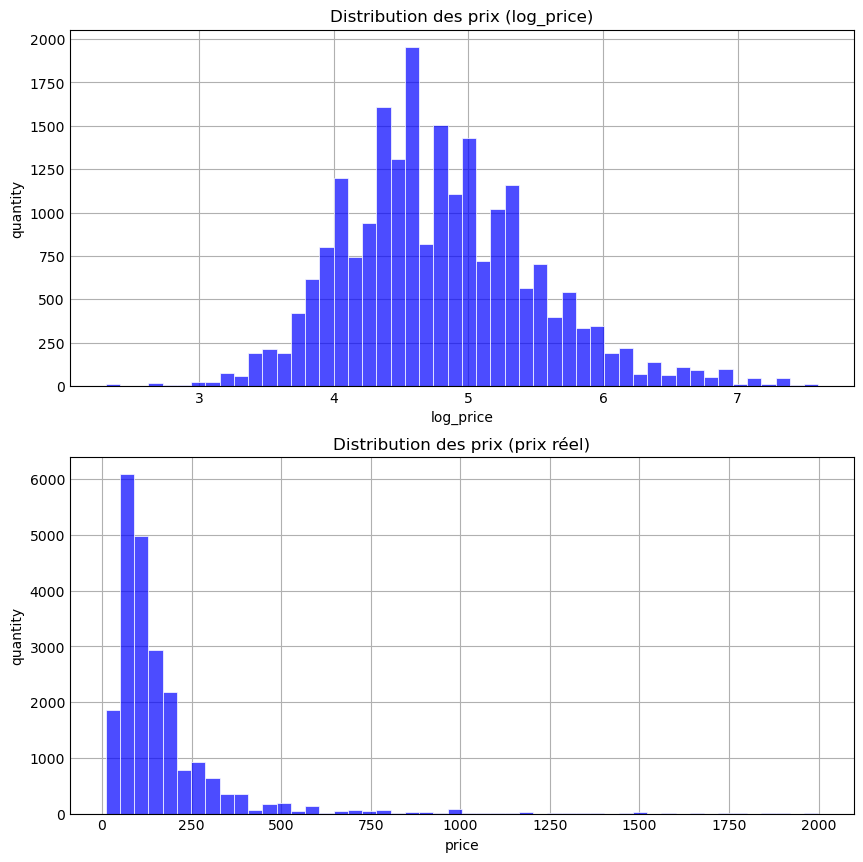

In [4]:
# Répartition des prix

%matplotlib inline

plt.style.use('_mpl-gallery')
fig = plt.figure(1, figsize=(8, 8))

X1 = data["log_price"].values

plt.subplot(211)
plt.title("Distribution des prix (log_price)")
plt.xlabel("log_price")
plt.ylabel("quantity")
plt.hist(X1, bins=50, color="blue", edgecolor="white", linewidth=0.7, alpha=0.7);

X2 = data["log_price"].apply(lambda x: np.exp(x)).values

plt.subplot(212)
plt.title("Distribution des prix (prix réel)")
plt.xlabel("price")
plt.ylabel("quantity")
plt.hist(X2, bins=50, color="blue", edgecolor="white", linewidth=0.7, alpha=0.7);

plt.show()

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/multiple_figs_demo.html#sphx-glr-gallery-subplots-axes-and-figures-multiple-figs-demo-py

On constate que la représentation des prix normaux est très asymétrique, ce qui donnerait une moyenne très élevée et assez peu représentative de l'échantillon, là où pour le logarithme du prix, la distribution est plus uniforme. 

On travaillera donc avec le logarithme du prix, d'autant que le modèle doit prédire ce dernier.

L'utilisation du logarithme pose cependant une interrogation quant à l'erreur que commettra le modèle. En effet, une erreur de 0.3 par exemple, sur une valeur de log assez élevée peut sembler peu, mais lors du passage du passage à l'exponentielle, cela peut se rapporter à un fort écart de prix.

### Dans la suite, on s'intéressera donc parfois au prix et non au log_price.

In [5]:
data["price"] = data["log_price"].apply(lambda x: np.exp(x)).values

# 2. Variables quantitatives et Type de propriété

On peut effectivement commencer par afficher une matrice de corrélation de notre dataset :

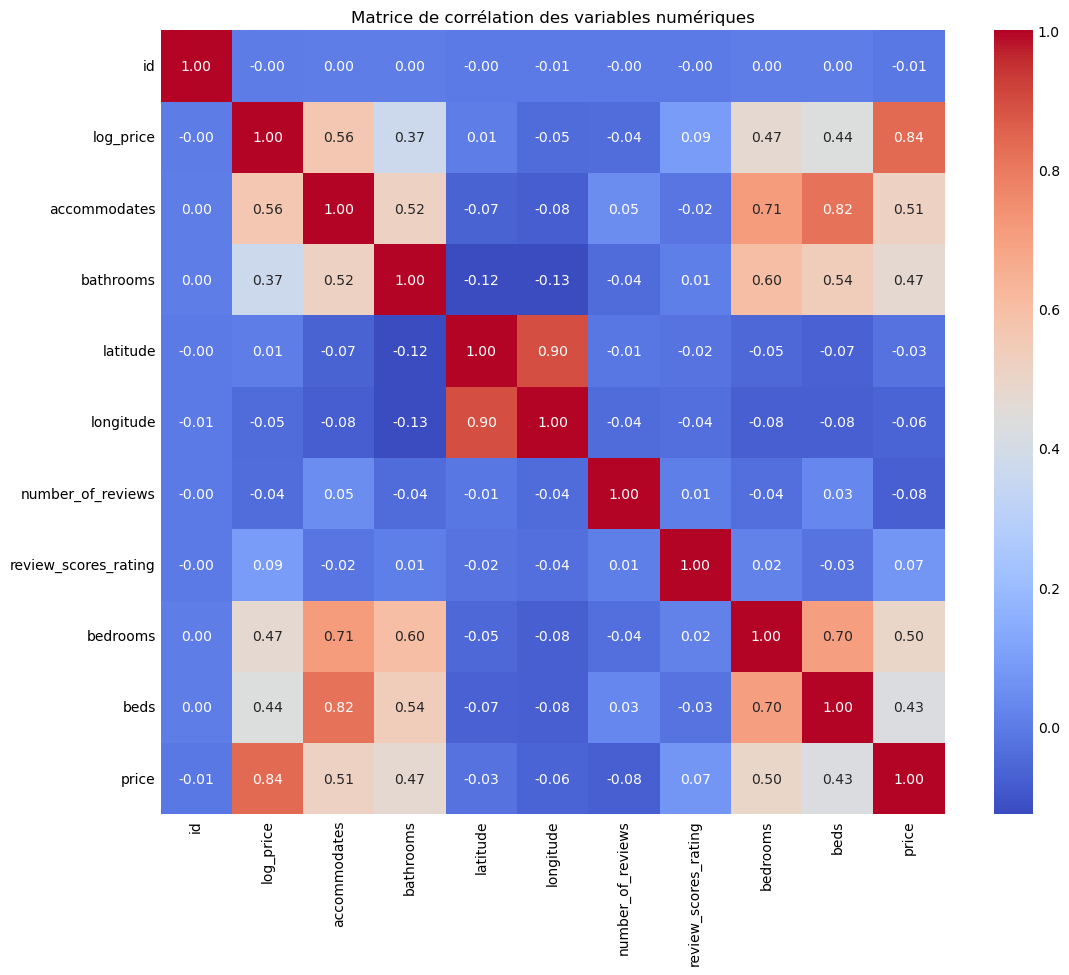

In [6]:
plt.figure(figsize=(10, 8))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

On observe qu'on a une plutôt forte corrélation entre certaines colonnes comme beds et bedrooms (plutôt logique). Ce qui pourrait nous donner envie de faire de l'analyse en composantes principales. Néanmoins, cela réduirait très peu le nombre de colonnes (celui-ci étant déjà très élevé à cause des variables qualitatives, que l'on va justement traiter afin de ne pas avoir un nombre trop important de colonnes dans le dataset). On y reviendra après.

### Passons au property_type pour l'instant

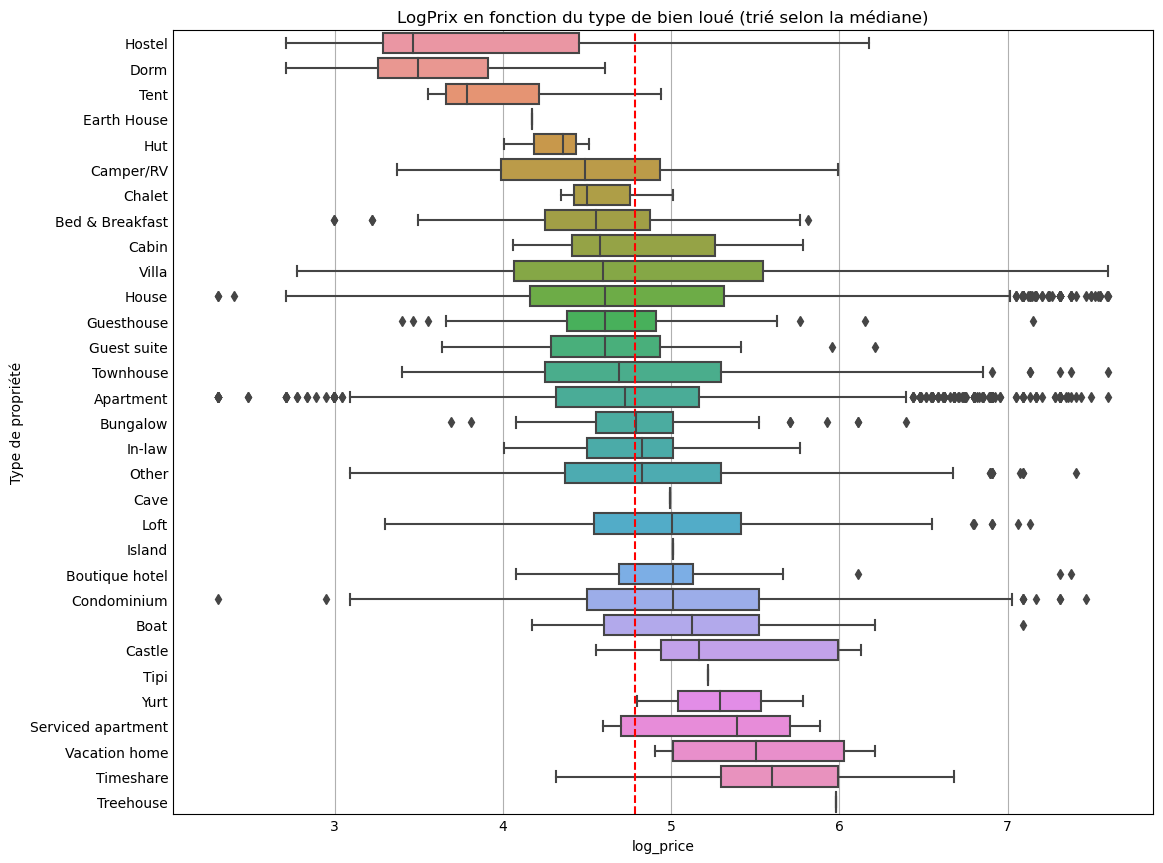

In [7]:
# Log_price selon le property_type

# Calculate the median order based on log_price grouped by property_type
median_order = data.groupby("property_type")["log_price"].median().sort_values(ascending=True).index

fig = plt.figure(figsize=(10, 8))

sns.boxplot(data=data, x="log_price", y="property_type", order=median_order)

plt.title("LogPrix en fonction du type de bien loué (trié selon la médiane)")
plt.xlabel("log_price")
plt.ylabel("Type de propriété")

plt.axvline(data["log_price"].mean(), color="red", linestyle="--", label="Moyenne globale")

plt.show()

# https://www.stat4decision.com/fr/le-box-plot-ou-la-fameuse-boite-a-moustache/
# https://seaborn.pydata.org/generated/seaborn.boxplot.html

Essayons d'afficher la corrélation entre les property_type et le prix :

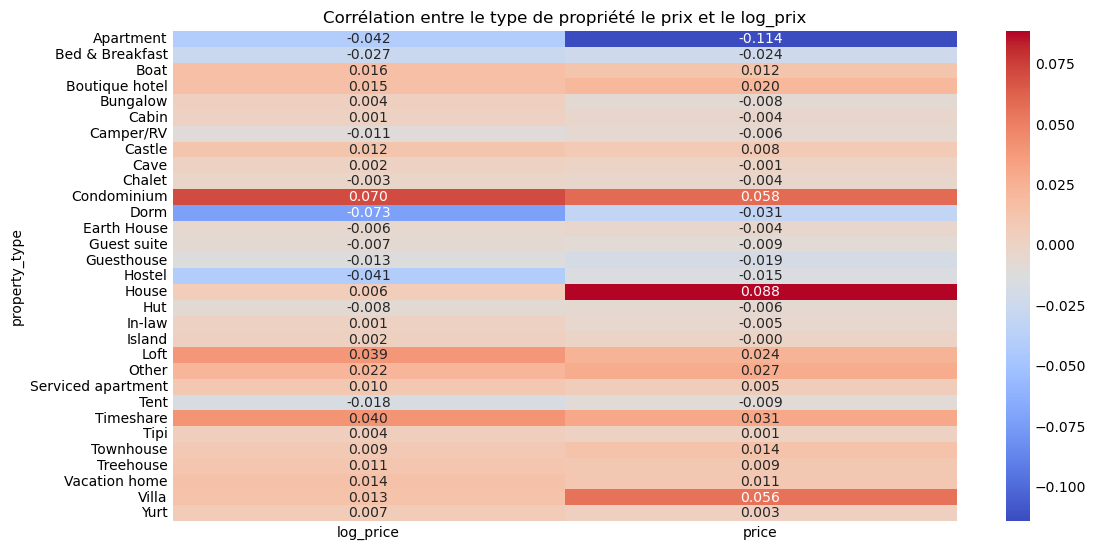

In [8]:
property_dummies = pd.get_dummies(data['property_type'])
corr_data = pd.concat([data[['log_price', 'price']], property_dummies], axis=1)
corr_matrix = corr_data.corr()

# Pour affichage juste avec les colonnes plutôt que la matrice complète
corr_log_price = corr_matrix.loc[property_dummies.columns, 'log_price'].sort_values(ascending=False)
corr_price = corr_matrix.loc[property_dummies.columns, 'price'].sort_values(ascending=False)

# Affichage

plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame({'log_price': corr_log_price, 'price': corr_price}), annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre le type de propriété le prix et le log_prix')
plt.ylabel('property_type')
plt.show()

On observe que certains types de propriétés ont vraisemblablement plus ou moins d'impact selon que l'on considère le price ou le log_price, en l'occurrence, cela est dû à l'écrasement provoqué par le log. Une question qu'on se posera tout le long, de cette étude est le choix entre essayer de prédire price, ou log_price pour avoir le meilleur modèle.

# 3. Lits chambres et salles de bains

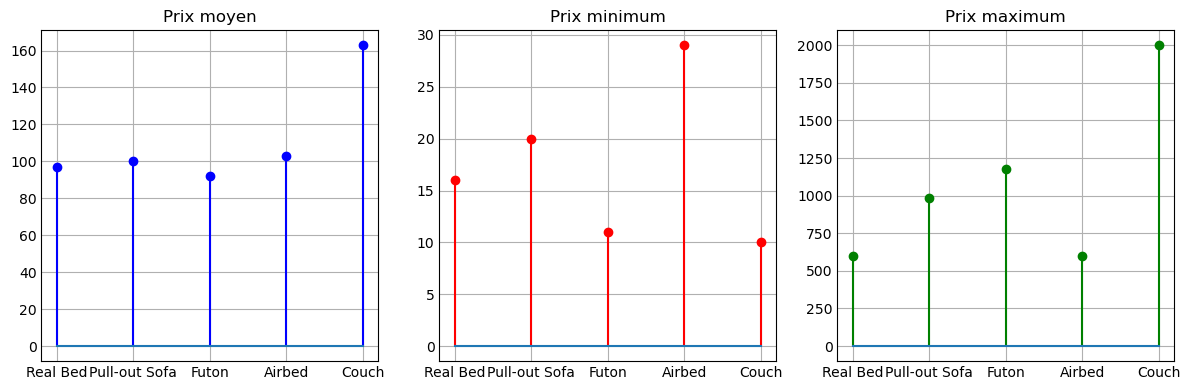

In [9]:
# Prix en fonction du type de lits

plt.style.use('_mpl-gallery')

X = data["bed_type"].unique()
y1 = data.groupby("bed_type")["price"].mean()
y2 = data.groupby("bed_type")["price"].min()
y3 = data.groupby("bed_type")["price"].max()

fig = plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title("Prix moyen")
plt.stem(X, y1, linefmt="blue");

plt.subplot(132)
plt.title("Prix minimum")
plt.stem(X, y2, linefmt="red");

plt.subplot(133)
plt.title("Prix maximum")
plt.stem(X, y3, linefmt="green");

plt.tight_layout()
plt.show()


# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/demo_tight_layout.html#sphx-glr-gallery-subplots-axes-and-figures-demo-tight-layout-py

In [10]:
# Calcul de l'écart-type du prix pour chaque type de lit
std_by_bed_type = data.groupby("bed_type")["price"].std()
print(std_by_bed_type)

bed_type
Airbed            94.545961
Couch            124.555806
Futon            111.912474
Pull-out Sofa     71.142107
Real Bed         171.604515
Name: price, dtype: float64


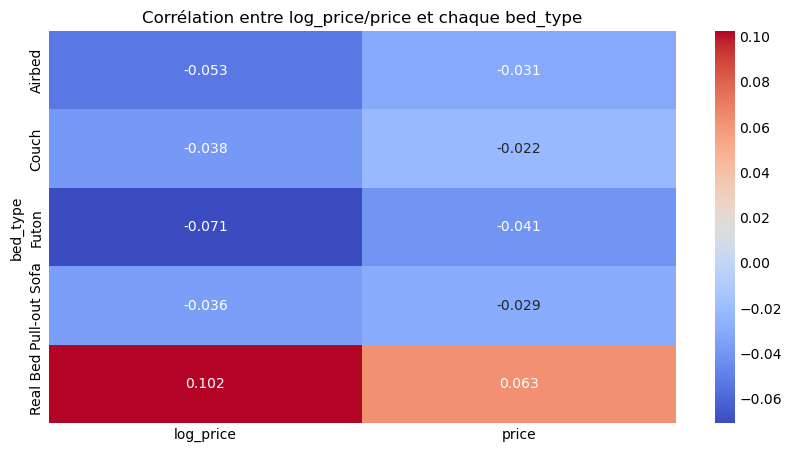

In [11]:
bed_type_dummies = pd.get_dummies(data['bed_type'])
corr_data_bed = pd.concat([data[['log_price', 'price']], bed_type_dummies], axis=1)
corr_matrix_bed = corr_data_bed.corr()

corr_log_price_bed = corr_matrix_bed.loc[bed_type_dummies.columns, 'log_price'].sort_values(ascending=False)
corr_price_bed = corr_matrix_bed.loc[bed_type_dummies.columns, 'price'].sort_values(ascending=False)

# Affichage

plt.figure(figsize=(8, 4))
sns.heatmap(pd.DataFrame({'log_price': corr_log_price_bed, 'price': corr_price_bed}), annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre log_price/price et chaque bed_type')
plt.ylabel('bed_type')
plt.show()

## 3.1 Corrélation avec le nombre de salles de bain, de chambres, de lits et capacité.

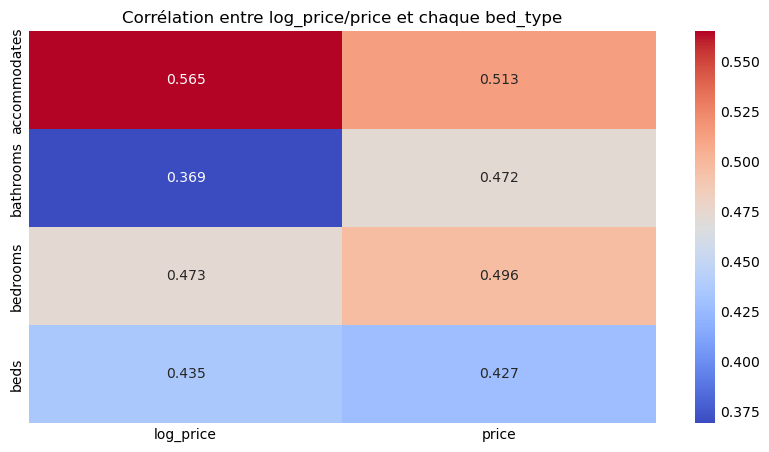

In [12]:
corr_data_bedbath = data[['log_price', 'price','bedrooms','bathrooms','beds','accommodates']]
corr_matrix_bedbath = corr_data_bedbath.corr()

corr_log_price_bedbath = corr_matrix_bedbath.loc[['bedrooms','bathrooms','beds','accommodates'], 'log_price'].sort_values(ascending=False)
corr_price_bedbath = corr_matrix_bedbath.loc[['bedrooms','bathrooms','beds','accommodates'], 'price'].sort_values(ascending=False)

# Affichage

plt.figure(figsize=(8, 4))
sns.heatmap(pd.DataFrame({'log_price': corr_log_price_bedbath, 'price': corr_price_bedbath}), annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre log_price/price et chaque bed_type')
plt.show()


Ici on aura choisi d'afficher le prix pour mieux se rendre compte de l'impact du lit. A noter qu'on affiche aussi l'écart-type de ces valeurs, sachant que plus l'écart-type est élevé, moins cela est pertinent...

Les trois dernières colonnes dont on a affiché la corrélation sont celles ayant le plus d'impact sur le log_price / le price, de loin comparativement au reste.

# 4. Les équipements

## 4.1. Pré-traitement

On va commencer par régler le problème lié au format de "amenities" dans le dataframe qui est un long string.

In [13]:
# Pré-traitement pour amenities

def clean_amenities(amenities_str):
    if pd.isna(amenities_str):
        return []
    cleaned_str = amenities_str.replace('{', '').replace('}', '').replace('"', '')
    amenities_list = cleaned_str.split(',')
    return amenities_list

# Application sur la colonne

if (type(data['amenities'][0]) != list): # Pour vérifier si elle n'est pas déjà transformée afin d'éviter les erreurs
    data['amenities'] = data['amenities'].apply(clean_amenities)

unique_amenities = []
series = data['amenities']
for l in series:
    for e in l:
        if (e not in unique_amenities):
            unique_amenities.append(e)

In [14]:
# A exécuter pour la vérification si besoin
def affiche():
    print("Nombre d'amenities uniques : ", len(unique_amenities))
    print("Liste des amenities uniques : ")
    for e in unique_amenities:
        print(e) # Mieux si scrollable dans ce sens

# affiche()

On commence simplement par se demander s'il existe une corrélation entre le nombre d'équipements et le prix. On rajoute donc une colonne "count_amenities" puis on affiche la corrélation avec le prix / le log_prix

In [15]:
data['count_amenities'] = data['amenities'].apply(len)

Corrélation entre count_amenities et le log_prix : 0.20


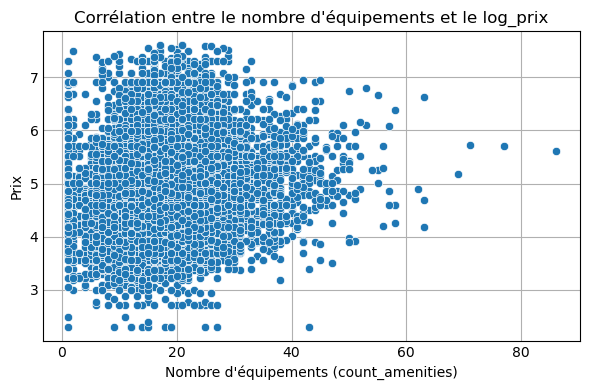

In [16]:
# Log_prix

correlation_log = data['count_amenities'].corr(data['log_price'])
print(f"Corrélation entre count_amenities et le log_prix : {correlation_log:.2f}")

# Visualisation
plt.figure(figsize=(6, 4))

sns.scatterplot(x='count_amenities', y='log_price', data=data, alpha=1)
plt.title('Corrélation entre le nombre d\'équipements et le log_prix')
plt.xlabel('Nombre d\'équipements (count_amenities)')
plt.ylabel('Prix')
plt.tight_layout()
plt.show()

Corrélation entre count_amenities et le log_prix : 0.13


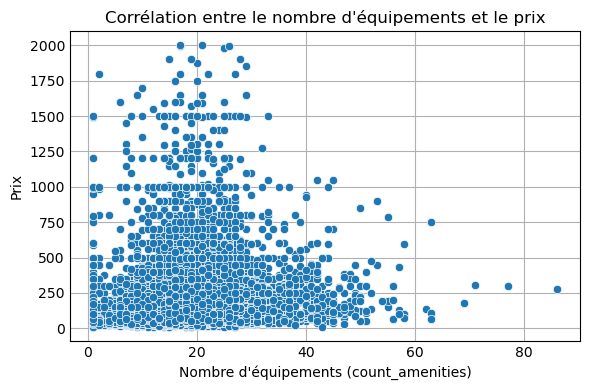

In [17]:
# Prix normal

correlation = data['count_amenities'].corr(data['price'])
print(f"Corrélation entre count_amenities et le log_prix : {correlation:.2f}")

# Visualisation
plt.figure(figsize=(6, 4))

sns.scatterplot(x='count_amenities', y='price', data=data, alpha=1)
plt.title('Corrélation entre le nombre d\'équipements et le prix')
plt.xlabel('Nombre d\'équipements (count_amenities)')
plt.ylabel('Prix')
plt.tight_layout()
plt.show()

Pour le log_price, on observe qu'on a une meilleure corrélation avec log_price. mais c'est loin d'être très bon. A l'inverse, visuellement on voit que lorsqu'on passe un certain nombre d'amenities, les airbnb ne dépassent plus un certain prix.

## 4.2. Regroupement des équipements

Lors de la première tentative d'exécution du modèle, nous avons utilisé un OneHotEncoder sur tous les équipements existant dans le DataFrame, néanmoins, cela est coûteux en ressources et en temps. C'est pourquoi nous tentons de regrouper les équipements afin de minimiser le nombre de colonnes que contiendra le DataFrame qu'utilisera notre modèle.

### 4.2.1 Regroupement par catégories

Nous avons d'abord tenté de regrouper les équipements dans plusieurs groupes "logiques" a priori. 

In [18]:
# On regroupe les commodités par catégories afin d'essayer d'identifier celles qui influencent le plus le prix.

grouped_amenities_v0 = {
    'Basic': ['TV', 'Wireless Internet', 'Internet', 'Kitchen', 'Heating', 'Air conditioning', 'Refrigerator', 'Essentials', 'Shampoo', 'Hot water'],
    'Safety': ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit', 'Safety card'],
    'Family': ['Family/kid friendly', 'Crib', 'Children’s books and toys', 'High chair', 'Outlet covers', 'Baby bath', 'Changing table', 'Baby monitor', 'Stair gates'],
    'Luxury': ['Hot tub', 'Pool', 'Gym', 'Sauna', 'Jacuzzi', 'Indoor fireplace', 'Private pool', 'Outdoor pool', 'Shared pool'],
    'Accessibility': ['Elevator', 'Step-free access', 'Wide entryway', 'Accessible-height bed', 'Wide clearance to bed', 'Flat smooth pathway to front door', 'Well-lit path to entrance'],
    'Extras': ['Laptop friendly workspace', 'Hangers', 'Hair dryer', 'Iron', 'Lock on bedroom door', 'Bed linens', 'Microwave', 'Coffee maker', 'Dishes and silverware', 'Cooking basics', 'Oven', 'Stove', 'Luggage dropoff allowed', 'EV charger']
}

data_copy = data.copy()

for category in grouped_amenities_v0:
    data_copy[category] = 0
    for ligne in data_copy.index:
        if any((amenity in data_copy.loc[ligne,"amenities"]) for amenity in grouped_amenities_v0[category]):
            data_copy.loc[ligne,category] = 1

# Pour chaque catégorie, il faut faire la moyenne des endroits où ça vaut 1.

moyennes = {}
for category in grouped_amenities_v0:
    moyennes[category] = data_copy.loc[data_copy[category]==1]["log_price"].mean()

pd.DataFrame(moyennes.items(), columns=["Category", "Mean Price"])

,Category,Mean Price
0,Basic,4.785157
1,Safety,4.794367
2,Family,4.988818
3,Luxury,5.000306
4,Accessibility,4.951547
5,Extras,4.790087


Il s'avère qu'on ne distingue pas de différence très significative de moyenne de prix pour chaque hébergement contenant au moins une catégorie d'équipements. De plus, le dictionnaire doit être réalisé à la main, ce qui peut être contraignant. Afin d'essayer d'exploiter au mieux ces données, nous avons donc réalisé une deuxième tentative.

### 4.2.2 Regroupement par influence sur le prix

Cette fois-ci, pour chaque équipement, on cherche la moyenne de prix des hébergements dans lesquels il est présent. Coûteux en temps mais à réaliser une seule fois. On aura ainsi des catégories selon l'impact sur le prix, mais plus précises et complètes qu'avant en théorie.



In [19]:
# Pré-traitement pour log_price

data_hf_log = data.copy()

for amenity in unique_amenities:
    data_hf_log[amenity] = 0
    for ligne in data.index:
        if amenity in data_hf_log.loc[ligne,"amenities"]:
            data_hf_log.loc[ligne, amenity] = 1

moyennes_log = {}
for amenity in unique_amenities:
    moyennes_log[amenity] = data_hf_log.loc[data_hf_log[amenity]==1]["log_price"].mean()

df2_log = pd.DataFrame(moyennes_log.items(), columns=["Amenity", "Mean log_price"])

C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2903900444.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_hf_log[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2903900444.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_hf_log[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2903900444.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

Le bloc s'exécute en 3-4 minutes sur ma machine, ce qui est largement raisonnable.

In [20]:
# Affichage

df2_log.head(10)

,Amenity,Mean log_price
0,TV,4.905704
1,Wireless Internet,4.789294
2,Kitchen,4.808184
3,Free parking on premises,4.829494
4,Pets allowed,4.923201
5,Suitable for events,5.102964
6,Washer,4.883748
7,Dryer,4.890013
8,Smoke detector,4.799002
9,Essentials,4.800494


In [21]:
log_mean = data.log_price.mean()
print(log_mean)

4.783480914904761


In [22]:
# Pré-traitement pour price

data_hf = data.copy()

for amenity in unique_amenities:
    data_hf[amenity] = 0
    for ligne in data_hf.index:
        if amenity in data_hf.loc[ligne,"amenities"]:
            data_hf.loc[ligne, amenity] = 1

moyennes = {}
for amenity in unique_amenities:
    moyennes[amenity] = data_hf.loc[data_hf[amenity]==1]["price"].mean()

df2 = pd.DataFrame(moyennes.items(), columns=["Amenity", "Mean price"]);

C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2653583000.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_hf[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2653583000.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_hf[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\2653583000.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [23]:
df2.head(10)

,Amenity,Mean price
0,TV,180.357822
1,Wireless Internet,161.402196
2,Kitchen,164.618100
3,Free parking on premises,179.021767
4,Pets allowed,189.300893
5,Suitable for events,250.312883
6,Washer,182.777505
7,Dryer,183.753691
8,Smoke detector,162.155108
9,Essentials,162.217697


In [24]:
mean = data.price.mean()
print(mean)

160.9715300890528


On note en observant les valeurs dans ce dataframe que les "équipements" peuvent avoir un impact significatif sur le prix. On remarque par exemple que les airbnbs pouvant être utilisés pour des événements sont plus chers en moyenne (en comparant à la moyenne globale)

On peut alors les regrouper par catégories en fonction de leur impact. Une question importante est comment choisir les seuils à partir desquels on considère que l'équipement a un impact négligeable (low), moyen (medium) ou fort (high).

In [25]:
# log_price
# Maintenant on peut essayer de les regrouper par catégories

grouped_amenities_log = {'High-': [],
                     'Medium-': [],
                     'Low': [], 
                     'Medium+': [], 
                     'High+': []}

for id in df2_log.index:

    # Cas négatif
    if df2_log.iloc[id]["Mean log_price"] - mean < -0.5:
        grouped_amenities_log['High-'].append(df2_log.iloc[id]["Amenity"])

    elif df2_log.iloc[id]["Mean log_price"] - mean < -0.1:
        grouped_amenities_log['Medium-'].append(df2_log.iloc[id]["Amenity"])

    # Entre -0.1 et 0.1
    elif df2_log.iloc[id]["Mean log_price"] - mean < 0.1:
        grouped_amenities_log['Low'].append(df2_log.iloc[id]["Amenity"])
    
    # Cas positif
    elif df2_log.iloc[id]["Mean log_price"] - mean < 0.5:
        grouped_amenities_log['Medium+'].append(df2_log.iloc[id]["Amenity"])
    else:
        grouped_amenities_log['High+'].append(df2_log.iloc[id]["Amenity"])

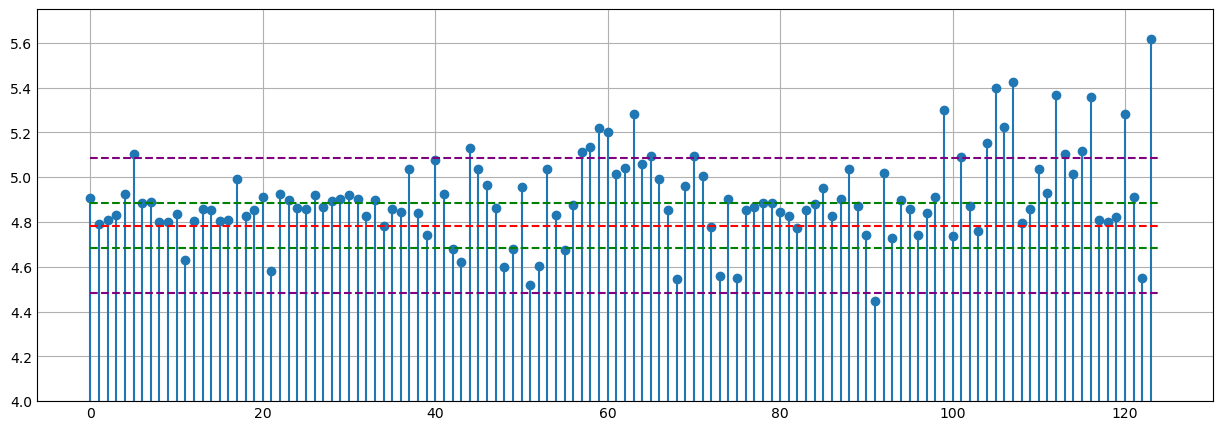

In [26]:
# log_price affichage

X = df2_log.index.values
y = df2_log["Mean log_price"].values
y = np.array(y)

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylim(4, 5.75)

plt.stem(X, y)
plt.plot(log_mean*np.ones(len(X)), color="red", linestyle='--');


plt.plot((log_mean+0.1)*np.ones(len(X)), color="green", linestyle='--');
plt.plot((log_mean-0.1)*np.ones(len(X)), color="green", linestyle='--');

plt.plot((log_mean+0.3)*np.ones(len(X)), color="purple", linestyle='--');
plt.plot((log_mean-0.3)*np.ones(len(X)), color="purple", linestyle='--');

plt.show()

In [27]:
# price
# Maintenant on peut essayer de les regrouper par catégories

grouped_amenities = {'High-': [],
                     'Medium-': [],
                     'Low': [], 
                     'Medium+': [], 
                     'High+': []}

for id in df2.index:

    # Cas négatif
    if df2.iloc[id]["Mean price"] - mean < -0.5:
        grouped_amenities['High-'].append(df2.iloc[id]["Amenity"])

    elif df2.iloc[id]["Mean price"] - mean < -0.1:
        grouped_amenities['Medium-'].append(df2.iloc[id]["Amenity"])

    # Entre -0.1 et 0.1
    elif df2.iloc[id]["Mean price"] - mean < 0.1:
        grouped_amenities['Low'].append(df2.iloc[id]["Amenity"])
    
    # Cas positif
    elif df2.iloc[id]["Mean price"] - mean < 0.5:
        grouped_amenities['Medium+'].append(df2.iloc[id]["Amenity"])
    else:
        grouped_amenities['High+'].append(df2.iloc[id]["Amenity"])

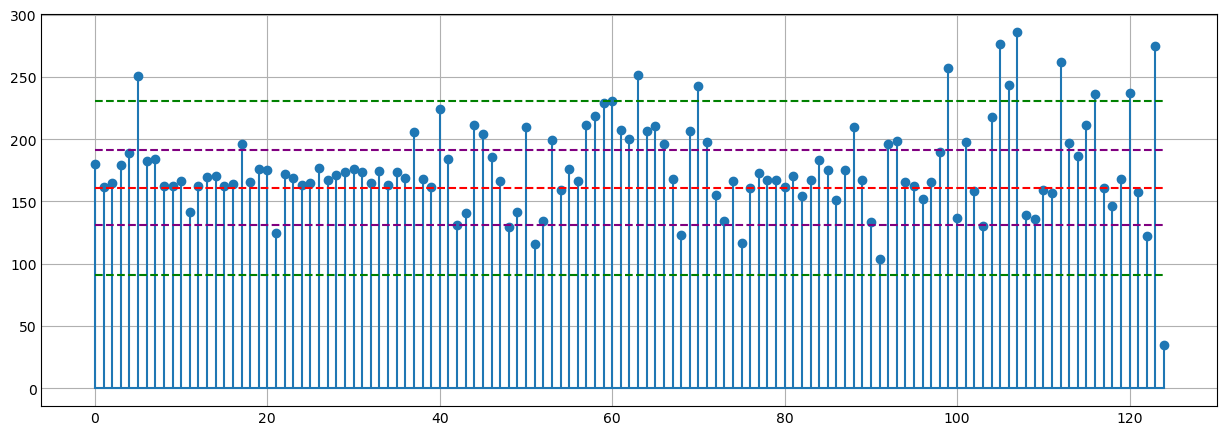

In [28]:
# price affichage

X = df2.index.values
y = df2["Mean price"].values
y = np.array(y)

fig, ax = plt.subplots(figsize=(12, 4))

plt.stem(X, y)
plt.plot(mean*np.ones(len(X)), color="red", linestyle='--');

plt.plot((mean+70)*np.ones(len(X)), color="green", linestyle='--');
plt.plot((mean-70)*np.ones(len(X)), color="green", linestyle='--');

plt.plot((mean+30)*np.ones(len(X)), color="purple", linestyle='--');
plt.plot((mean-30)*np.ones(len(X)), color="purple", linestyle='--');

plt.show()

D'abord, on observe pas de différence majeure entre log_price et price pour les écarts à la moyennes, si ce n'est que le grpahique pour price est moins compact (ce qui est logique) et donc plus lisible. Le point important est surtout que pour price l'échelle est "linéaire" là où en affichant le log, on a en réalité une échelle logarithmique sur le prix.

Ces données sont intéressantes, mais il est important de se demander si elles sont réellement pertinentes. Pour cela, on pourrait ne prendre en compte que celles qui apparaissent au moins X fois dans les données par exemple. Une exception ne fait pas la règle, et cela pourrait biaiser notre modèle. De plus, cela diminuera le nombre de colonnes et améliorera l'efficacité de notre modèle.

Recommençons le raisonnement mais uniquement sur les amenities les plus fréquentes.

### 4.2.3 Regroupement en catégories, avec condition de fréquence d'apparition

In [29]:
# count_amenities cette fois-ci compte le nombre de fois qu'elles apparaissent dans le dataset, 
# pas comme avant quand on comptait le nombre d'équipements par logement.

# log_price

data_copy = data.copy()

count_amenities = {}
for amenity in unique_amenities:
    count_amenities[amenity] = 0
    for ligne in data_copy.index:
        if amenity in data_copy.loc[ligne,"amenities"]:
            count_amenities[amenity] += 1

relevant_amenities = [key for key in count_amenities if count_amenities[key] > 50]

for amenity in relevant_amenities:
    data_copy[amenity] = 0
    for ligne in data.index:
        if amenity in data_copy.loc[ligne,"amenities"]:
            data_copy.loc[ligne, amenity] = 1

moyennes_log = {}
for amenity in relevant_amenities:
    moyennes_log[amenity] = data_copy.loc[data_copy[amenity]==1]["log_price"].mean()

df3_log = pd.DataFrame(moyennes_log.items(), columns=["Amenity", "Mean log_price"])

C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\45713059.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\45713059.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[amenity] = 0
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\45713059.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

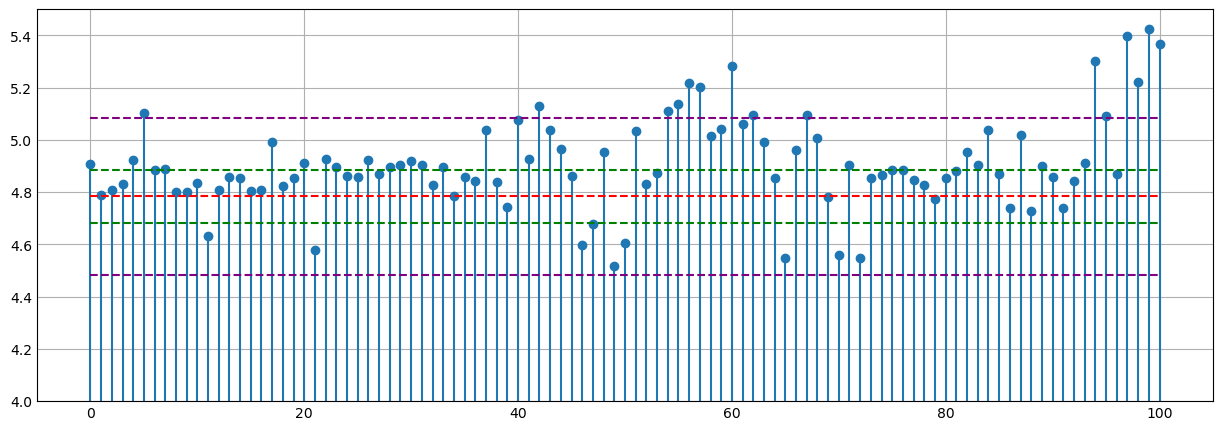

In [30]:
# log_price affichage

X = df3_log.index.values
y = df3_log["Mean log_price"].values
y = np.array(y)

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylim(4, 5.5)

plt.stem(X, y)
plt.plot(log_mean*np.ones(len(X)), color="red", linestyle='--');

plt.plot((log_mean+0.1)*np.ones(len(X)), color="green", linestyle='--');
plt.plot((log_mean-0.1)*np.ones(len(X)), color="green", linestyle='--');

plt.plot((log_mean+0.3)*np.ones(len(X)), color="purple", linestyle='--');
plt.plot((log_mean-0.3)*np.ones(len(X)), color="purple", linestyle='--');

plt.show()

In [31]:
# price

moyennes = {}
for amenity in relevant_amenities:
    moyennes[amenity] = data_copy.loc[data_copy[amenity]==1]["price"].mean()

df3 = pd.DataFrame(moyennes.items(), columns=["Amenity", "Mean price"])

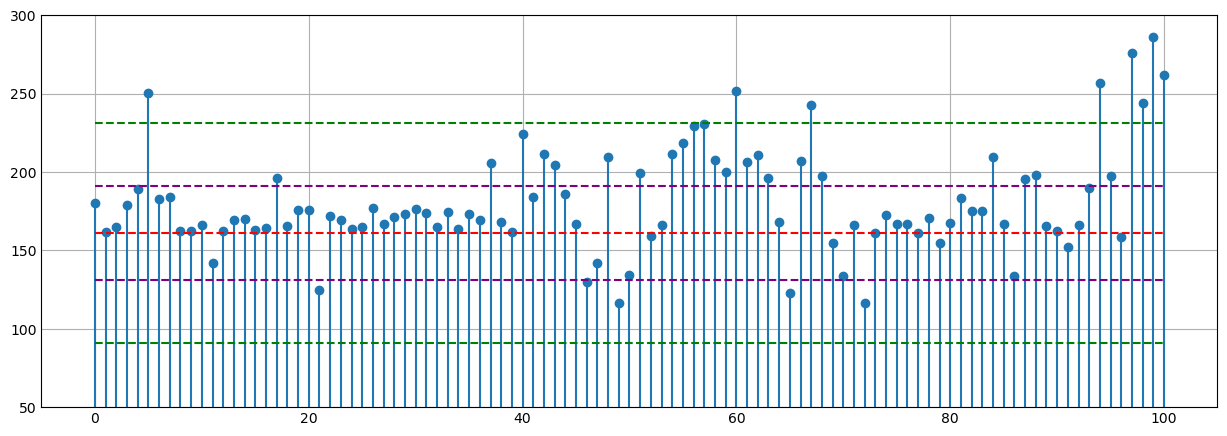

In [32]:
# price affichage

X = df3.index.values
y = df3["Mean price"].values
y = np.array(y)

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylim(50, 300)

plt.stem(X, y)
plt.plot(mean*np.ones(len(X)), color="red", linestyle='--');


plt.plot((mean+70)*np.ones(len(X)), color="green", linestyle='--');
plt.plot((mean-70)*np.ones(len(X)), color="green", linestyle='--');

plt.plot((mean+30)*np.ones(len(X)), color="purple", linestyle='--');
plt.plot((mean-30)*np.ones(len(X)), color="purple", linestyle='--');

plt.show()

In [33]:
# Finalement on peut les regrouper et ne récupérer que les plus éloignées de la moyenne.
# pour log_price
final_grouped_amenities_log = {'High-': [], 'Medium-': [], 'Low': [], 'Medium+': [], 'High+': []}

for idx, row in df3_log.iterrows():
    amenity = row["Amenity"]
    mean_log_price = row["Mean log_price"]
    if mean_log_price - log_mean < -0.5:
        final_grouped_amenities_log['High-'].append(amenity)
    elif mean_log_price - log_mean < -0.1:
        final_grouped_amenities_log['Medium-'].append(amenity)
    elif mean_log_price - log_mean < 0.1:
        continue
    elif mean_log_price - log_mean < 0.5:
        final_grouped_amenities_log['Medium+'].append(amenity)
    else:
        final_grouped_amenities_log['High+'].append(amenity)

In [34]:
# Finalement on peut les regrouper et ne récupérer que les plus éloignées de la moyenne.
# pour price
final_grouped_amenities = {'High-': [], 'Medium-': [], 'Low': [], 'Medium+': [], 'High+': []}

for idx, row in df3.iterrows():
    amenity = row["Amenity"]
    mean_price = row["Mean price"]
    if mean_price - mean < -0.5:
        final_grouped_amenities['High-'].append(amenity)
    elif mean_price - mean < -0.1:
        final_grouped_amenities['Medium-'].append(amenity)
    elif mean_price - mean < 0.1:
        continue
    elif mean_price - mean < 0.5:
        final_grouped_amenities['Medium+'].append(amenity)
    else:
        final_grouped_amenities['High+'].append(amenity)

In [35]:
print("Final amenities log_price : ", final_grouped_amenities_log)
print("Final amenities price : ", final_grouped_amenities)

Final amenities log_price :  {'High-': [], 'Medium-': ['Lock on bedroom door', 'translation missing: en.hosting_amenity_50', 'Pets live on this property', 'Dog(s)', 'translation missing: en.hosting_amenity_49', 'Private living room', 'Cat(s)', 'Smoking allowed', 'Host greets you'], 'Low': [], 'Medium+': ['TV', 'Pets allowed', 'Suitable for events', 'Washer', 'Dryer', 'Family/kid friendly', '24-hour check-in', 'Self Check-In', 'Keypad', 'Coffee maker', 'Dishes and silverware', 'Cooking basics', 'Oven', 'Stove', 'Elevator in building', 'Cable TV', 'BBQ grill', 'Garden or backyard', 'Doorman', 'Gym', 'Elevator', 'Hot tub', 'Private entrance', 'Outlet covers', 'Children’s books and toys', 'Pack ’n Play/travel crib', 'Children’s dinnerware', 'Game console', 'Bathtub', 'High chair', 'Room-darkening shades', 'Dishwasher', 'Patio or balcony', 'Pool', 'Indoor fireplace', 'Wheelchair accessible', 'Lockbox', 'Flat', ' smooth pathway to front door', 'Smart lock', 'Window guards', 'Pocket wifi', 'E

On a des résultats qui semblent satisfaisants, on peut séparer clairement en plusieurs catégories les équipements et récupérer ceux dont l'impact est significatif. Qui plus est, on s'est assuré qu'ils ne sont pas de simples cas isolés mais des équipements plutôt récurrents dans les airbnbs. On peut essayer d'afficher la corrélation entre ces derniers et les log_price et price.

On a finalement plus les placer dans deux dictionnaires finaux, qui pourront servir à améliorer notre modèle.

# 5. La géographie

## 5.1 Visualisation

In [36]:
# Importations pour pouvoir utiliser les quartiers et zipcodes comme des couleurs
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\147616238.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["zipcode"] = filtered["zipcode"].fillna(900)
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\147616238.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["zipcode"] = filtered["zipcode"].apply(lambda x: str(x)[:3] if isinstance(x, str) else str(int(x))[:3])
C:\Users\antdu\AppData\Local\Temp\ipykernel_3492\147616238.py:45: SettingWithCopyWarning: 
A value is trying to be set on

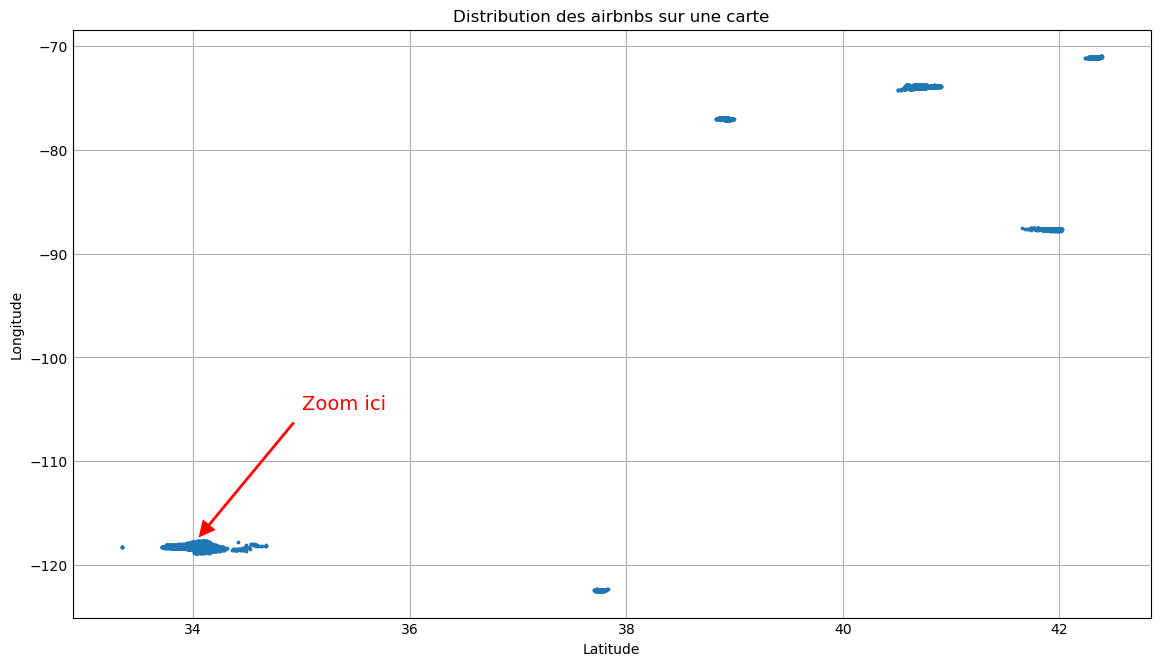

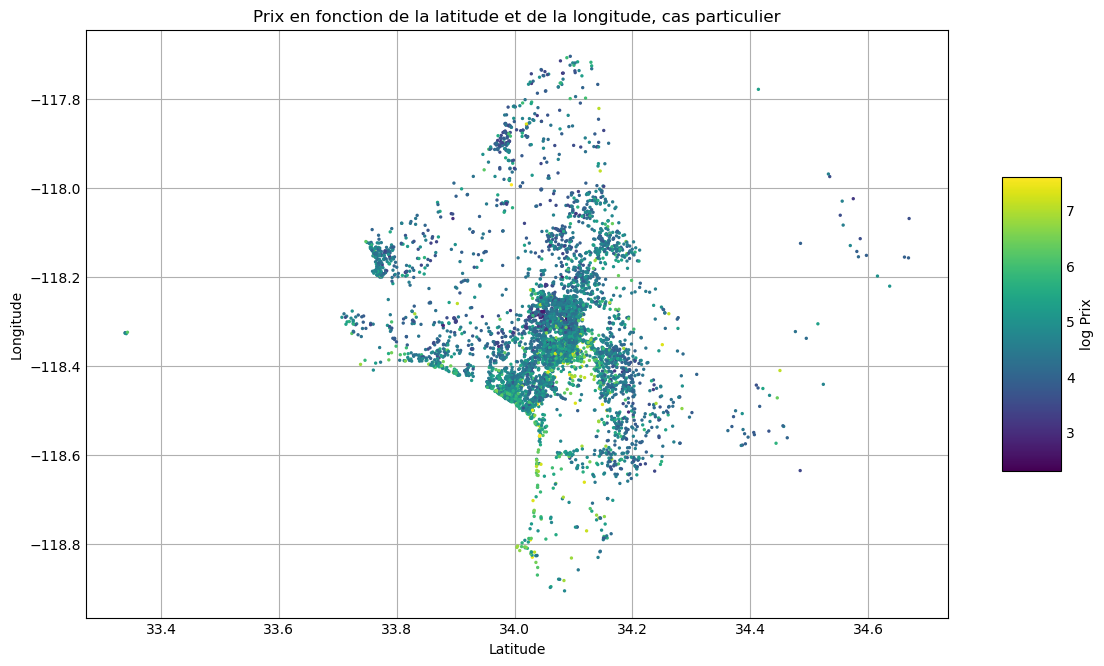

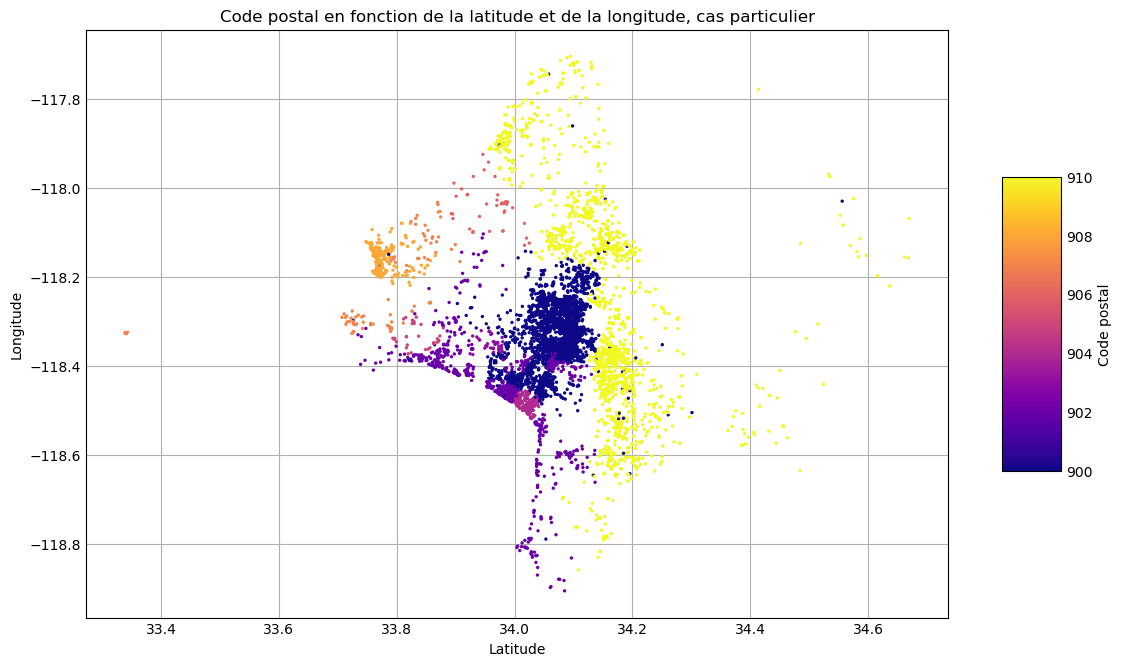

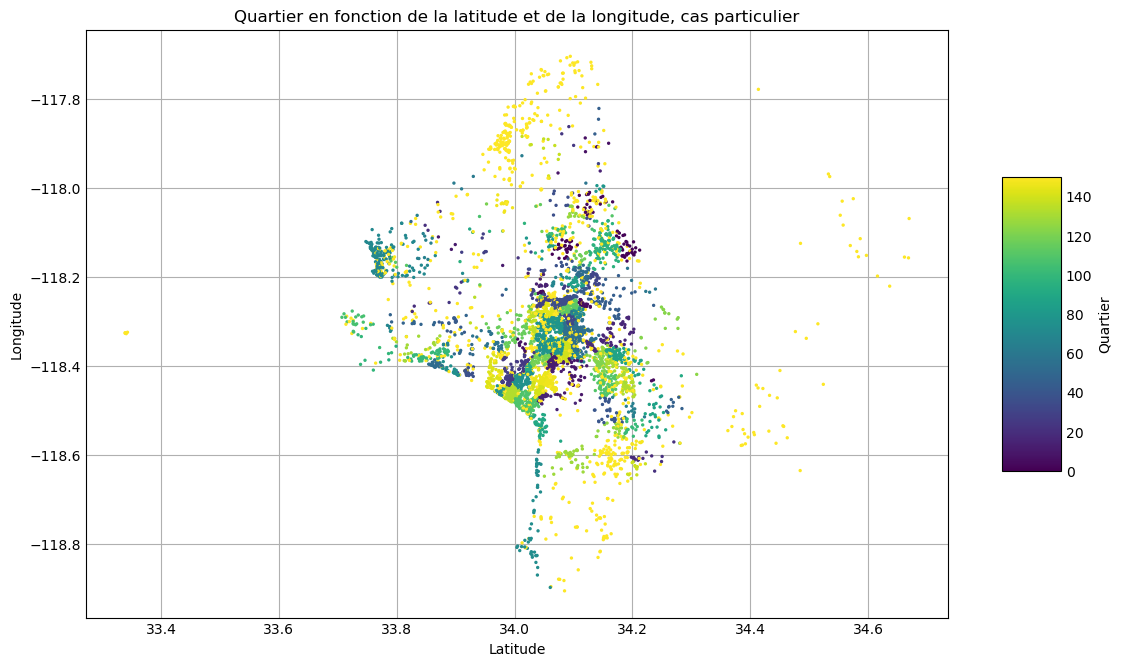

In [37]:
# Affichage des prix des airbnb en fonction de leur emplacement.
# Carte interactive pour visualiser.

# %matplotlib widget
# Ne fonctionne pas pour une raison que je ne comprends pas

fig, ax = plt.subplots(figsize=(11, 6))

x = data["latitude"].values
y = data["longitude"].values

ax.scatter(x, y, alpha=1, s=3)
ax.set_title("Distribution des airbnbs sur une carte")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

ax.annotate("Zoom ici", xy=(34, -118), xytext=(35, -105),
            arrowprops=dict(facecolor='red', edgecolor="None", shrink=0.05, width=2),
            fontsize=14, color='red'
)

# Deuxième graphique (log_price)

filtered = data[(data["latitude"] < 36) & (data["longitude"] < 110)]

fig, ax = plt.subplots(figsize=(11, 6))

x = filtered["latitude"].values
y = filtered["longitude"].values

plot = ax.scatter(x, y, c=filtered["log_price"], cmap='viridis', alpha=1, s=2)
ax.set_title("Prix en fonction de la latitude et de la longitude, cas particulier")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

fig.colorbar(plot, ax=ax, shrink=0.5, aspect=5, label="log Prix");


# Troisième (3 premiers chiffres du code postal) on ne prendra que les 3 premiers chiffres pour rendre le modèle plus rapide.

# Le problème est qu'il est trop difficiles de visualiser tous les zipcodes différents avec une palette de couleur

filtered["zipcode"] = filtered["zipcode"].fillna(900)
filtered["zipcode"] = filtered["zipcode"].apply(lambda x: str(x)[:3] if isinstance(x, str) else str(int(x))[:3])
filtered["zipcode"] = filtered["zipcode"].astype(int)

fig, ax = plt.subplots(figsize=(11, 6))

x = filtered["latitude"].values
y = filtered["longitude"].values

plot = ax.scatter(x, y, c=filtered["zipcode"], cmap='plasma', alpha=1, s=2, vmin=900, vmax=910)
ax.set_title("Code postal en fonction de la latitude et de la longitude, cas particulier")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

fig.colorbar(plot, ax=ax, shrink=0.5, aspect=5, label="Code postal");

# Quatrième graphique

le = LabelEncoder()
filtered["transformed_neighbourhood"] = le.fit_transform(filtered["neighbourhood"])

fig, ax = plt.subplots(figsize=(11, 6))

x = filtered["latitude"].values
y = filtered["longitude"].values

plot = ax.scatter(x, y, c=filtered["transformed_neighbourhood"], cmap='viridis', alpha=1, s=2)
ax.set_title("Quartier en fonction de la latitude et de la longitude, cas particulier")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

fig.colorbar(plot, ax=ax, shrink=0.5, aspect=5, label="Quartier");

plt.show()

# https://matplotlib.org/stable/users/explain/figure/interactive.html
# https://fr.matplotlib.net/stable/gallery/pyplots/annotation_basic.html
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py

On observe que la localisation d'un airbnb a un impact sur le prix. On peut distinguer sur le graphique plusieurs regroupements. Ainsi cela aide le modèle à déterminer le prix. Par exemple, le graphique sur le log_price coincide avec celui sur le quartier.

Lorsque l'on arrive à utiliser mpl widget, on peut mieux observer que les maisons semblent être regroupées en partie par prix.

In [38]:
neighbourhood_dummies = pd.get_dummies(data['neighbourhood'], prefix='neigh')
corr_data_neigh = pd.concat([data[['log_price', 'price']], neighbourhood_dummies], axis=1)
corr_matrix_neigh = corr_data_neigh.corr()

corr_log_price_neigh = corr_matrix_neigh.loc[neighbourhood_dummies.columns, 'log_price']
corr_price_neigh = corr_matrix_neigh.loc[neighbourhood_dummies.columns, 'price']

corr_df = pd.DataFrame({'log_price': corr_log_price_neigh,'price': corr_price_neigh})

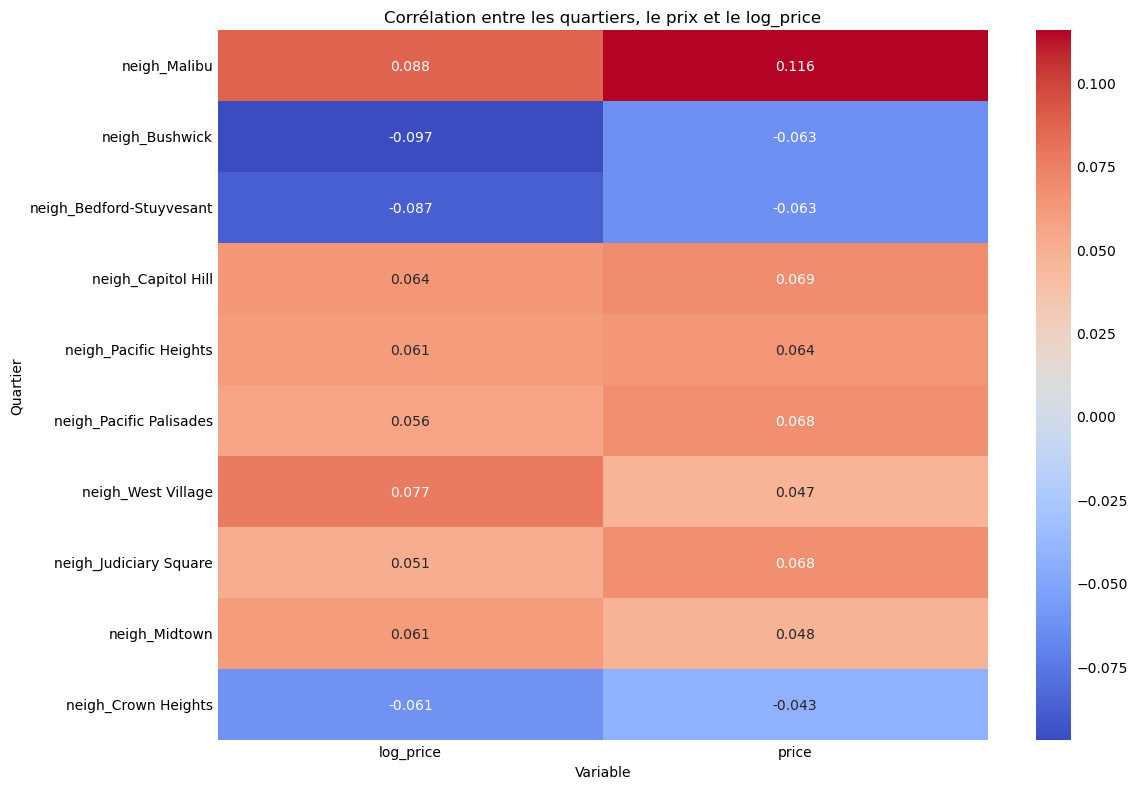

In [39]:
# On prend la somme des valeurs absolues des corrélations pour chaque quartier
corr_df['abs_sum'] = corr_df.abs().sum(axis=1)

# On sélectionne les 10 quartiers les plus corrélés
corr_df_lisible = corr_df.sort_values('abs_sum', ascending=False).head(10).drop(columns='abs_sum')

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df_lisible, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre les quartiers, le prix et le log_price')
plt.ylabel('Quartier')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

In [40]:
city_dummies = pd.get_dummies(data['city'])
corr_data_city = pd.concat([data[['log_price', 'price']], city_dummies], axis=1)
corr_matrix_city = corr_data_city.corr()

corr_log_price_city = corr_matrix_city.loc[city_dummies.columns, 'log_price']
corr_price_city = corr_matrix_city.loc[city_dummies.columns, 'price']

corr_df = pd.DataFrame({'log_price': corr_log_price_city,'price': corr_price_city})

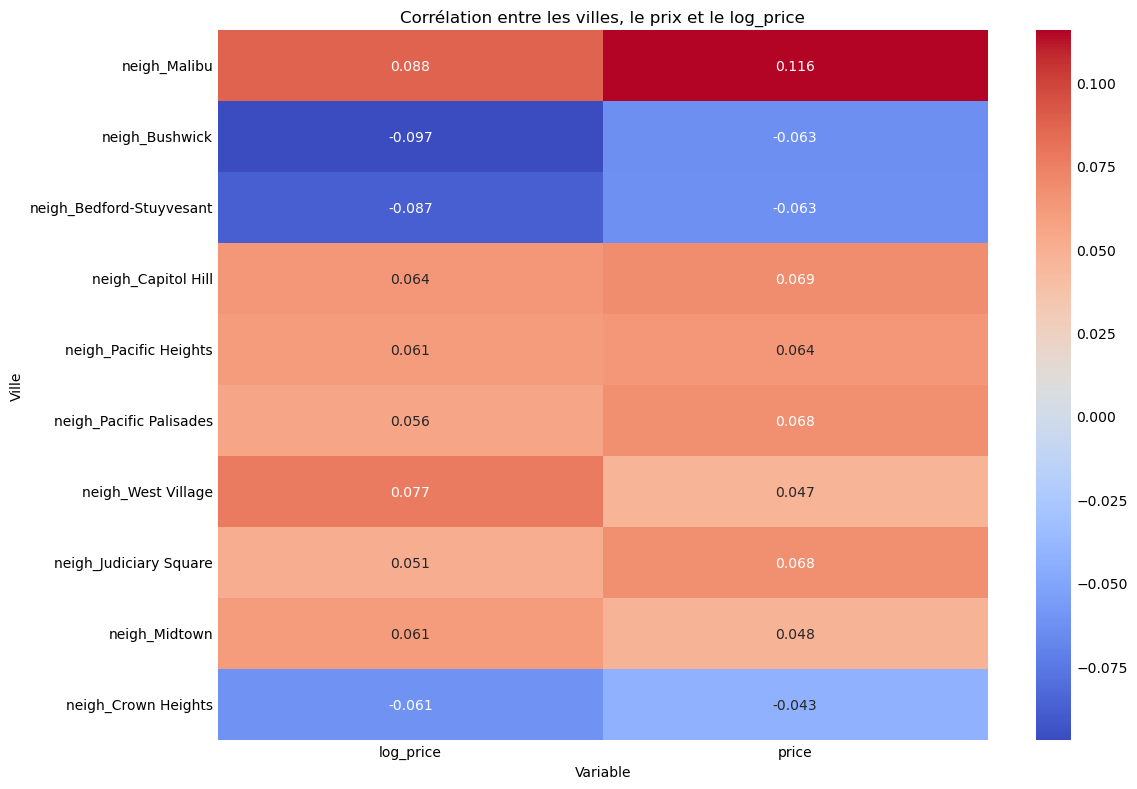

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df_lisible, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre les villes, le prix et le log_price')
plt.ylabel('Ville')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

Ici on n'a que des airbnb dans des grandes villes il faudrait se méfier. En effet, quand on observe le dataset, on observe que les prix ont l'air légèrement corrélés négativement avec NYC par exemple. Cependant, on ne prend en compte que des grandes villes des Etats-Unis, si on avait des petites villes dans le dataset, toutes ces grandes villes auraient des corrélations plus fortes, et les petites villes, elles potentiellement des corrélations très proche de -1, à côté de celles des grandes villes.

N'entrainer le dataset que sur des grandes villes n'est pas forcément une très bonne idée si on compte l'utiliser pour prédire le prix d'airbnbs dans de petites villes. Là-bas tous les critères changent.

# 6. Qualité de l'hôte

Number of reviews et score reviews sont déjà des valeurs numériques. On ne les changera donc pas. On va se concentrer sur le reste : cancellation policy, cleaning fee, description, name, first_review, host_has_profile_pic, host_identity_verified, host_response_rate, instant_bookable, host_since, last_review (ça en fait beaucoup)

In [42]:
# Pour commencer : 

unique_values = {
    'cancellation_policy': data['cancellation_policy'].unique().tolist(),
    'cleaning_fee': data['cleaning_fee'].unique().tolist(),
    'first_review': data['first_review'].unique().tolist(),
    'host_has_profile_pic': data['host_has_profile_pic'].unique().tolist(),
    'host_identity_verified': data['host_identity_verified'].unique().tolist(),
    'host_response_rate': data['host_response_rate'].unique().tolist(),
    'host_since': data['host_since'].unique().tolist(),
    'instant_bookable': data['instant_bookable'].unique().tolist(),
    'last_review': data['last_review'].unique().tolist()
}

# Affichage des valeurs uniques

for key, values in unique_values.items():
    print(f"{key} : {values}\n")

cancellation_policy : ['flexible', 'strict', 'moderate', 'super_strict_30', 'super_strict_60']

cleaning_fee : [False, True]

first_review : [nan, '2017-05-07', '2016-10-07', '2016-09-25', '2017-06-08', '2013-03-25', '2015-03-10', '2017-01-02', '2016-02-29', '2016-06-26', '2016-07-18', '2014-08-02', '2012-11-30', '2016-11-30', '2017-01-09', '2016-02-15', '2016-01-01', '2015-10-16', '2016-10-30', '2017-04-07', '2014-11-14', '2014-08-18', '2016-07-01', '2016-11-04', '2016-07-30', '2016-06-16', '2016-10-19', '2015-09-21', '2017-09-24', '2015-07-16', '2017-02-25', '2017-07-31', '2014-09-06', '2017-09-17', '2015-03-26', '2016-04-16', '2016-03-30', '2013-01-05', '2017-08-06', '2016-07-24', '2015-12-16', '2015-11-23', '2013-01-02', '2015-08-19', '2016-06-05', '2016-08-26', '2015-12-10', '2016-01-10', '2017-01-15', '2012-09-17', '2015-09-12', '2015-08-12', '2016-02-10', '2013-04-23', '2017-07-22', '2014-09-11', '2016-03-21', '2016-08-06', '2016-06-19', '2017-09-18', '2015-07-13', '2017-01-01',

In [43]:
# Remplacement des valeurs de cleaning_fee : False -> 'f', True -> 't'
data['cleaning_fee'] = data['cleaning_fee'].replace({False: 'f', True: 't'})

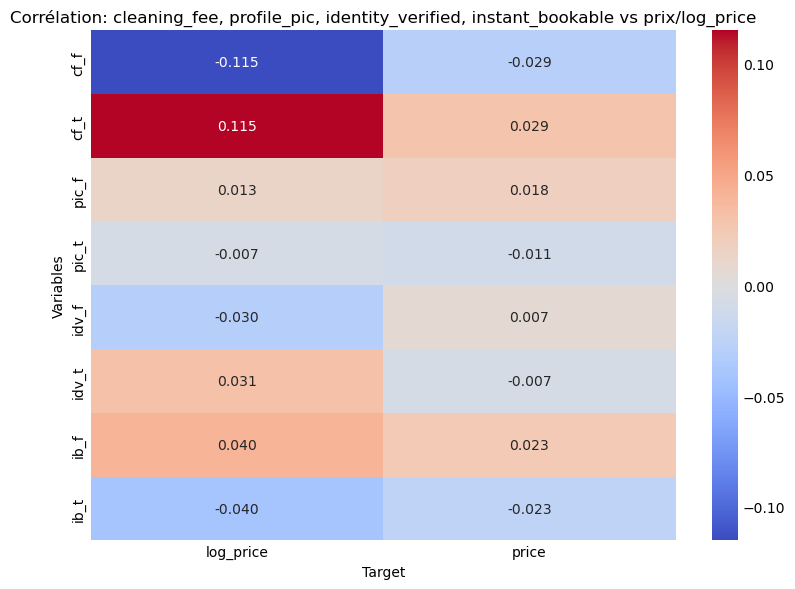

In [44]:
# Cleaning fee
cleaning_fee_dummies = pd.get_dummies(data['cleaning_fee'], prefix='cf')
# Host has profile pic
profile_pic_dummies = pd.get_dummies(data['host_has_profile_pic'], prefix='pic')
# Host identity verified
identity_verified_dummies = pd.get_dummies(data['host_identity_verified'], prefix='idv')
# Instant bookable
instant_bookable_dummies = pd.get_dummies(data['instant_bookable'], prefix='ib')

# Concat all
corr_data = pd.concat([
    data[['log_price', 'price']],
    cleaning_fee_dummies,
    profile_pic_dummies,
    identity_verified_dummies,
    instant_bookable_dummies
], axis=1)

corr_matrix = corr_data.corr()

# Extract correlations
corr_cleaning = corr_matrix.loc[cleaning_fee_dummies.columns, ['log_price', 'price']]
corr_pic = corr_matrix.loc[profile_pic_dummies.columns, ['log_price', 'price']]
corr_idv = corr_matrix.loc[identity_verified_dummies.columns, ['log_price', 'price']]
corr_ib = corr_matrix.loc[instant_bookable_dummies.columns, ['log_price', 'price']]

# Combine for display
corr_all = pd.concat([
    corr_cleaning,
    corr_pic,
    corr_idv,
    corr_ib
])

plt.figure(figsize=(8, 6))
sns.heatmap(corr_all, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation: cleaning_fee, profile_pic, identity_verified, instant_bookable vs prix/log_price')
plt.ylabel('Variables')
plt.xlabel('Target')
plt.tight_layout()
plt.show()

On constate que la photo de profil a réellement un impact très faible, on la supprimera donc du dataset. De même pour la description ou le name par ailleurs, on ne va pas se lancer dans l'utilisation d'outils comme NLToolkit dans un projet comme celui-ci. 

In [45]:
from datetime import datetime

# Fonction pour convertir une date en nombre de jours depuis aujourd'hui
def days_since_today(date_str):
    if pd.isna(date_str):
        return np.nan
    try:
        date = pd.to_datetime(date_str)
        ref_date = datetime.now()
        return (ref_date - date).days
    except Exception:
        return np.nan

for col in ['host_since', 'last_review', 'first_review']:
    data[col] = data[col].apply(days_since_today)

In [46]:
data.head(5)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,price,count_amenities
0,5708593,4.317488,House,Private room,"[TV, Wireless Internet, Kitchen, Free parking ...",3,1.0,Real Bed,flexible,f,...,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0,75.0,15
1,14483613,4.007333,House,Private room,"[Wireless Internet, Air conditioning, Kitchen,...",4,2.0,Real Bed,strict,f,...,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0,55.0,25
2,10412649,7.090077,Apartment,Entire home/apt,"[TV, Wireless Internet, Air conditioning, Kitc...",6,2.0,Real Bed,flexible,f,...,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0,1200.0,20
3,17954362,3.555348,House,Private room,"[TV, Cable TV, Internet, Wireless Internet, Ai...",1,1.0,Real Bed,flexible,t,...,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0,35.0,30
4,9969781,5.480639,House,Entire home/apt,"[TV, Cable TV, Internet, Wireless Internet, Ki...",4,1.0,Real Bed,moderate,t,...,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0,240.0,24


## 6.1 Politique d'annulation

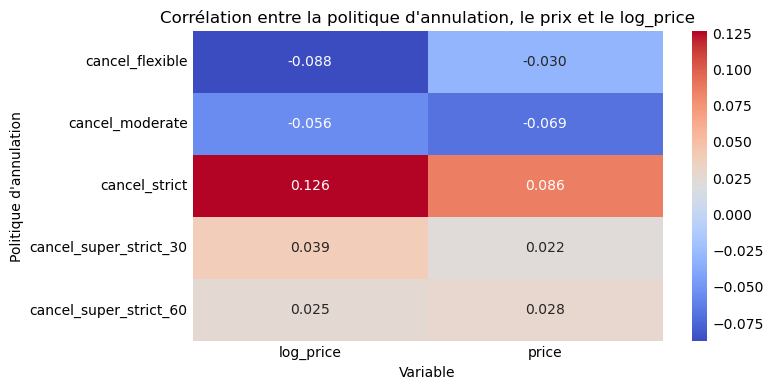

In [47]:
cancellation_dummies = pd.get_dummies(data['cancellation_policy'], prefix='cancel')
corr_data_cancel = pd.concat([data[['log_price', 'price']], cancellation_dummies], axis=1)
corr_matrix_cancel = corr_data_cancel.corr()

corr_log_price_cancel = corr_matrix_cancel.loc[cancellation_dummies.columns, 'log_price']
corr_price_cancel = corr_matrix_cancel.loc[cancellation_dummies.columns, 'price']

corr_cancel_df = pd.DataFrame({'log_price': corr_log_price_cancel, 'price': corr_price_cancel})

# Affichage 

plt.figure(figsize=(8, 4))
sns.heatmap(corr_cancel_df, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation entre la politique d\'annulation, le prix et le log_price')
plt.ylabel('Politique d\'annulation')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

On a ici des résultats intéressants. De fait, à première vue, on aurait pu penser à classer les politiques de la plus sévères à la moins sévère. Cela dit, ce graphique remet en cause notre première opinion, et de fait, il est vrai que généralement, des airbnbs de plus grandes valeurs auront une politique d'annulation stricte car ils seront peut-être plus demandés, présente un plus grand risque de perte en cas d'annulation etc... qu'un airbnb abordable. Néanmoins cela doit garder une proportion raisonnable, car une politique trop stricte influence moins positivement le prix qu'une politique stricte mais "juste".

On pourra prendre ça en compte lorsqu'on transformera cette colonne pour la rendre utilisable par notre modèle.

## 6.2 Dates

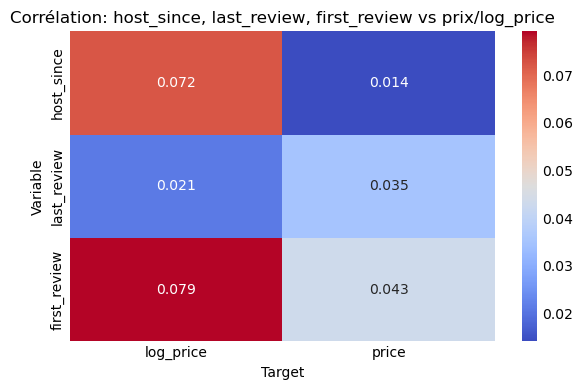

In [48]:
corr_data_dates = data[['log_price', 'price', 'host_since', 'last_review', 'first_review']]
corr_matrix_dates = corr_data_dates.corr()

corr_vars = ['host_since', 'last_review', 'first_review']
corr_log_price = corr_matrix_dates.loc[corr_vars, 'log_price']
corr_price = corr_matrix_dates.loc[corr_vars, 'price']

corr_dates_df = pd.DataFrame({'log_price': corr_log_price, 'price': corr_price})

# Affichage

plt.figure(figsize=(6, 4))
sns.heatmap(corr_dates_df, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation: host_since, last_review, first_review vs prix/log_price')
plt.ylabel('Variable')
plt.xlabel('Target')
plt.tight_layout()
plt.show()


On a un impact très faible, mais ce n'est "qu'une colonne".

## 6.3 Proportion de réponse

In [49]:
def ordRate(data:str):
    if pd.isna(data):
        return 0
    else:
        y = str(data)
        return float(y.replace('%', '')) / 100.0
    
data['host_response_rate'] = data['host_response_rate'].apply(ordRate)

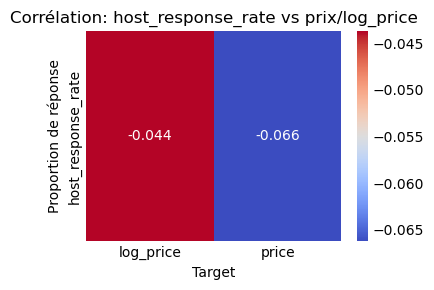

In [50]:
# Corrélation entre host_response_rate, price et log_price

corr_response = data[['host_response_rate', 'log_price', 'price']].corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr_response.loc[['host_response_rate'], ['log_price', 'price']], annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Corrélation: host_response_rate vs prix/log_price')
plt.ylabel('Proportion de réponse')
plt.xlabel('Target')
plt.tight_layout()
plt.show()

L'impact est encore une fois très faible, et un peu contre-intuitif. On peut peut-être imaginer les hôtes on plus tendance à répondre s'il y a des commentaires négatifs ? Ce qui expliquerait la corrélation négative. (Sur des valeurs aussi faibles cela relève purement de la spéculation mais c'est intéressant)

# 7. Conclusion

1. On retire name et description
2. On fera finalement une prédiction sur le log_price directement
3. On applique un OneHotEncoder sur property_type, bed_types, etc... sauf : amenities
4. On utilise ajoute 4 colonnes selon les final grouped amenities
5. On OneHotEncode bien le quartier
6. Pour le zipcode, on réduit aux 3 premiers chiffres
7. Pour l'hôte on pense à faire les transformations nécessaires et appliquer des OneHotEncoder quand il n'y a pas vraiment de relation d'ordre.